<a href="https://colab.research.google.com/github/Ryukijano/DL_audio/blob/hf_audio_course/voice_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We’ll piece together three models that we’ve already had hands-on experience with to build an end-to-end voice assistant called Marvin 🤖. Like Amazon’s Alexa or Apple’s Siri, Marvin is a virtual voice assistant who responds to a particular ‘wake word’, then listens out for a spoken query, and finally responds with a spoken answer.

We can break down the voice assistant pipeline into four stages, each of which requires a standalone model:

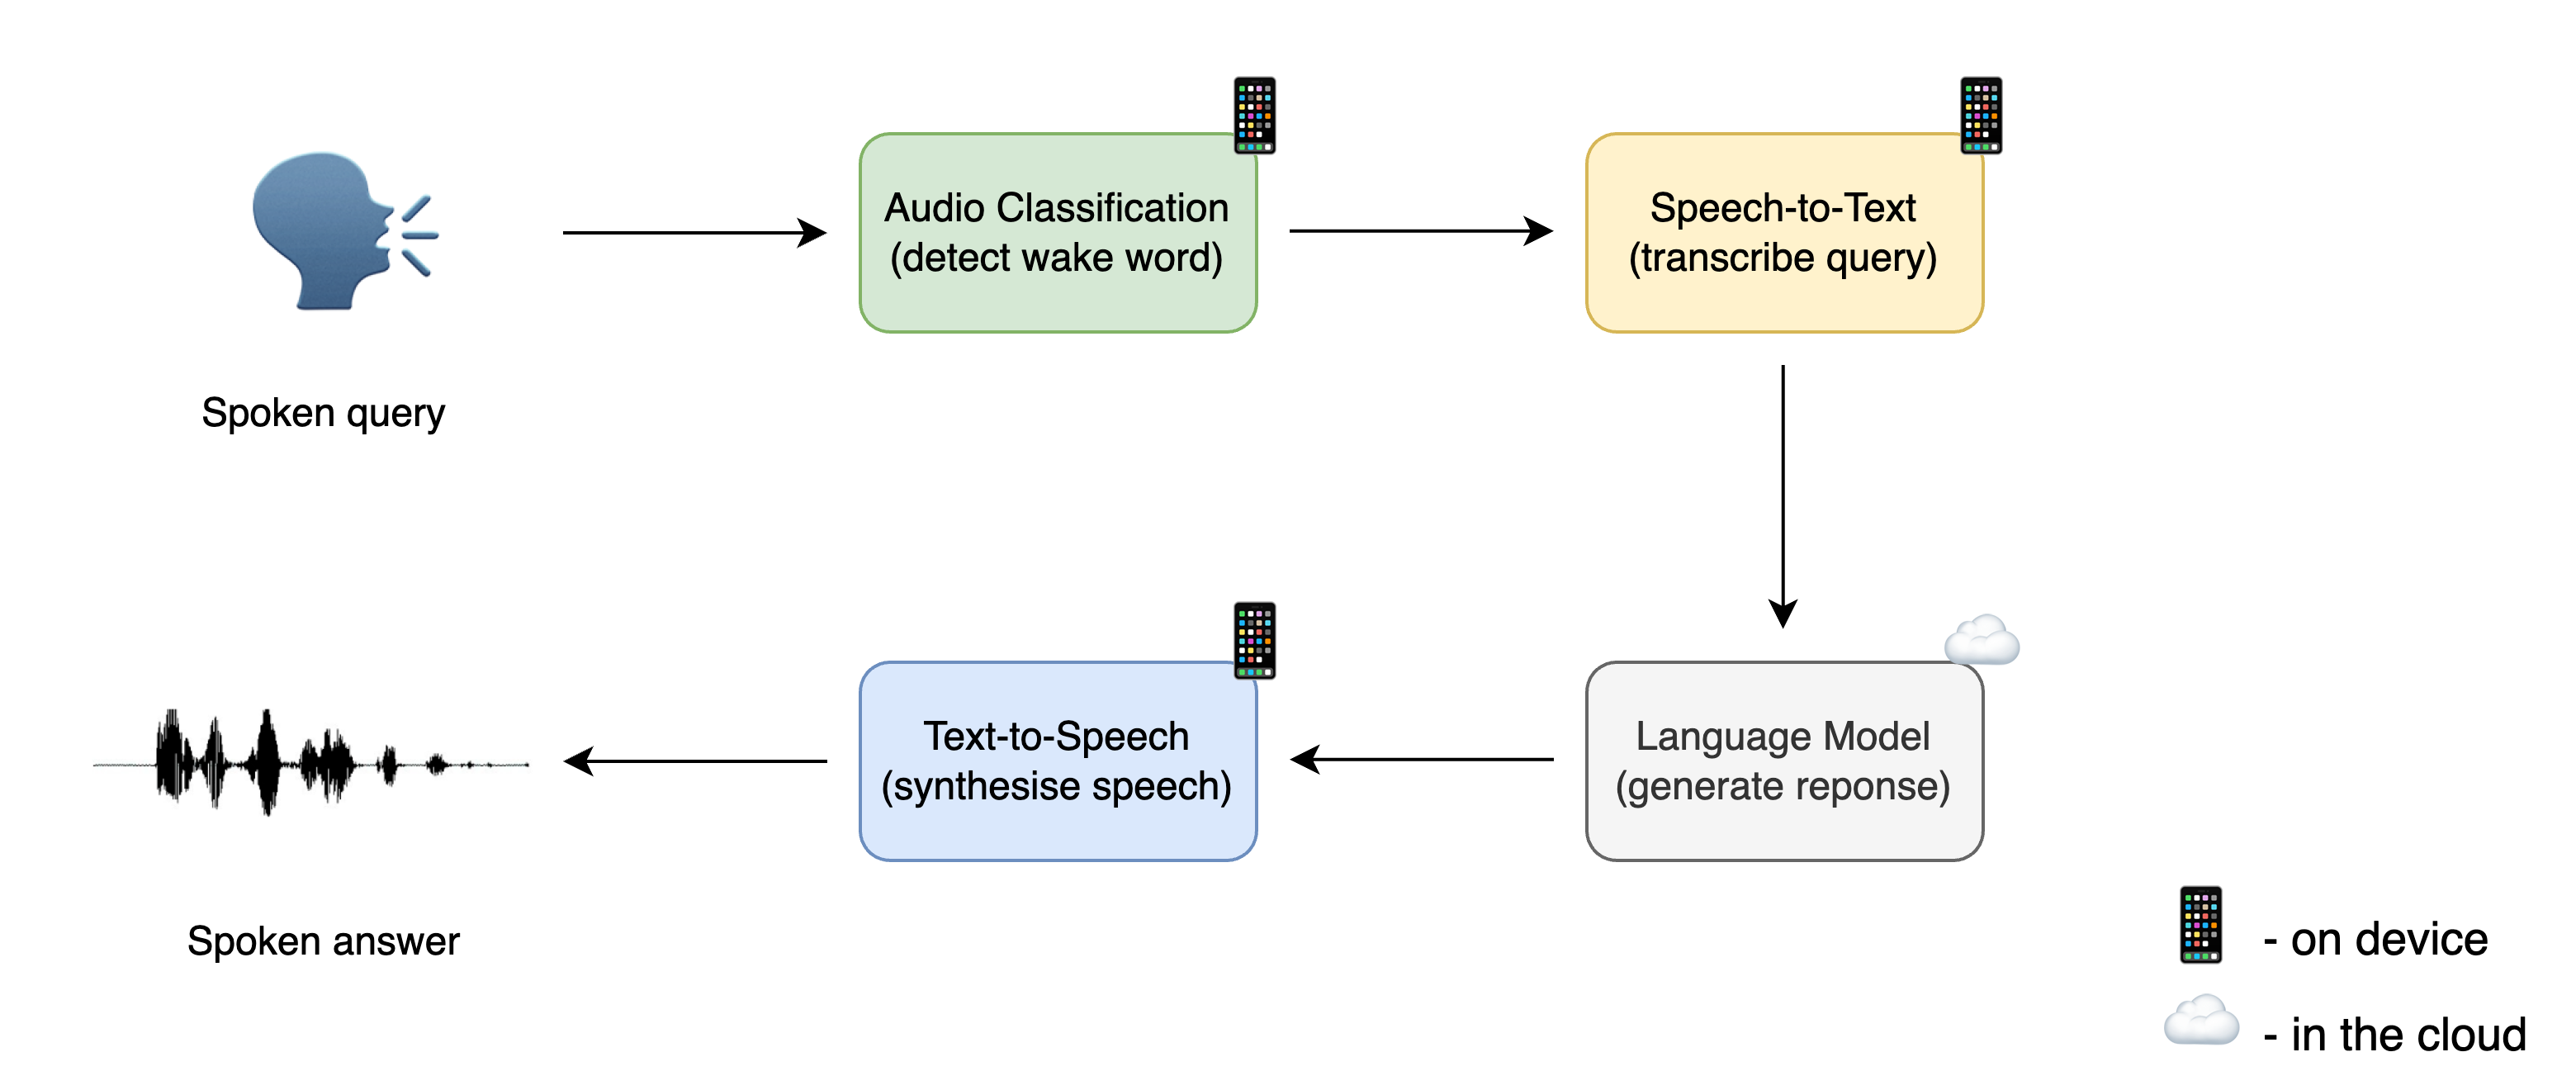


###1. Wake word detection


Voice assistants are constantly listening to the audio inputs coming through your device’s microphone, however they only boot into action when a particular ‘wake word’ or ‘trigger word’ is spoken.

The wake word detection task is handled by a small on-device audio classification model, which is much smaller and lighter than the speech recognition model, often only several millions of parameters compared to several hundred millions for speech recognition. Thus, it can be run continuously on your device without draining your battery. Only when the wake word is detected is the larger speech recognition model launched, and afterwards it is shut down again.

###2. Speech Trancription

The next stage in the pipeline is transcribing the spoken query to text. In practice, transferring audio files from your local device to the Cloud is slow due to the large nature of audio files, so it’s more efficient to transcribe them directly using an automatic speech recognition (ASR) model on-device rather than using a model in the Cloud. The on-device model might be smaller and thus less accurate than one hosted in the Cloud, but the faster inference speed makes it worthwhile since we can run speech recognition in near real-time, our spoken audio utterance being transcribed as we say it.

###3. Language model query

Now we want to generate a response! The best candidate models for this task are large language models (LLMs), since they are effectively able to understand the semantics of the text query and generate a suitable response.

Since our text query is small (just a few text tokens), and language models large (many billions of parameters), the most efficient way of running LLM inference is to send our text query from our device to an LLM running in the Cloud, generate a text response, and return the response back to the device.

###4. Synthesise Speech

Since our text query is small (just a few text tokens), and language models large (many billions of parameters), the most efficient way of running LLM inference is to send our text query from our device to an LLM running in the Cloud, generate a text response, and return the response back to the device.

###Wake word detection

The first stage in the voice assistant pipeline is detecting whether the wake word was spoken, and we need to find ourselves an appropriate pre-trained model for this task! Speech Commands is a dataset of spoken words designed to evaluate audio classification models on 15+ simple command words like "up", "down", "yes" and "no", as well as a "silence" label to classify no speech.

We can take an audio classification model pre-trained on the Speech Commands dataset and pick one of these simple command words to be our chosen wake word. Out of the 15+ possible command words, if the model predicts our chosen wake word with the highest probability, we can be fairly certain that the wake word has been said.

Let’s head to the Hugging Face Hub and click on the “Models” tab: https://huggingface.co/models

This is going to bring up all the models on the Hugging Face Hub, sorted by downloads in the past 30 days:

Loading the checkpoint using the pipeline class

In [2]:
!pip install transformers -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.0 MB/s eta 0:00:00


In [1]:

from transformers import pipeline
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"

classifier = pipeline(
    "audio-classification", model="MIT/ast-finetuned-speech-commands-v2", device=device
)

In [2]:
#checking the labels that the model was trained on by checking the id2label attribute in the model config:
classifier.model.config.id2label



{0: 'backward',
 1: 'follow',
 2: 'five',
 3: 'bed',
 4: 'zero',
 5: 'on',
 6: 'learn',
 7: 'two',
 8: 'house',
 9: 'tree',
 10: 'dog',
 11: 'stop',
 12: 'seven',
 13: 'eight',
 14: 'down',
 15: 'six',
 16: 'forward',
 17: 'cat',
 18: 'right',
 19: 'visual',
 20: 'four',
 21: 'wow',
 22: 'no',
 23: 'nine',
 24: 'off',
 25: 'three',
 26: 'left',
 27: 'marvin',
 28: 'yes',
 29: 'up',
 30: 'sheila',
 31: 'happy',
 32: 'bird',
 33: 'go',
 34: 'one'}

We see that the model was trained on 35 class labels, including some simple command words that we described above, as well as some particular objects like "bed", "house" and "cat". We see that there is one name in these class labels: id 27 corresponds to the label "marvin"

In [3]:
classifier.model.config.id2label[27]

'marvin'

In [4]:
'marvin'

'marvin'

We will use this name as our wake word for this voice assistant. Of all possible labels, if th emodel predicts "marvin" with the highest class probability, we can be fairly sure that our chosen wake word has been said.

Now we need to define a function that is constantly listening to our device's microphone input, and continously passes the audio to the classification model for inference. To do this, we will use a handy helper function that comes with  🤗 Transformers called [ffmpeg_microphone_live](https://github.com/huggingface/transformers/blob/fb78769b9c053876ed7ae152ee995b0439a4462a/src/transformers/pipelines/audio_utils.py#L98)

This function forwards small chunks of audio of specified length chunk_length_s to the model to be classified. To ensure that we get smooth boundaries across chunks of audio, we run a sliding window across our audio with stride chunk_length_s / 6. So that we don’t have to wait for the entire first chunk to be recorded before we start inferring, we also define a minimal temporary audio input length stream_chunk_s that is forwarded to the model before chunk_length_s time is reached.

The function ffmpeg_microphone_live returns a generator object, yielding a sequence of audio chunks that can each be passed to the classification model to make a prediction. We can pass this generator directly to the pipeline, which in turn returns a sequence of output predictions, one for each chunk of audio input. We can inspect the class label probabilities for each audio chunk, and stop our wake word detection loop when we detect that the wake word has been spoken.

We’ll use a very simple criteria for classifying whether our wake word was spoken: if the class label with the highest probability was our wake word, and this probability exceeds a threshold prob_threshold, we declare that the wake word as having been spoken. Using a probability threshold to gate our classifier this way ensures that the wake word is not erroneously predicted if the audio input is noise, which is typically when the model is very uncertain and all the class label probabilities low. You might want to tune this probability threshold, or explore more sophisticated means for the wake word decision through an [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory) (or uncertainty) based metric.

In [5]:
from transformers.pipelines.audio_utils import ffmpeg_microphone_live


def launch_fn(
    wake_word="marvin",
    prob_threshold=0.5,
    chunk_length_s=2.0,
    stream_chunk_s=0.25,
    debug=False,
):
    if wake_word not in classifier.model.config.label2id.keys():
        raise ValueError(
            f"Wake word {wake_word} not in set of valid class labels, pick a wake word in the set {classifier.model.config.label2id.keys()}."
        )

    sampling_rate = classifier.feature_extractor.sampling_rate

    mic = ffmpeg_microphone_live(
        sampling_rate=sampling_rate,
        chunk_length_s=chunk_length_s,
        stream_chunk_s=stream_chunk_s,
    )

    print("Listening for wake word...")
    for prediction in classifier(mic):
        prediction = prediction[0]
        if debug:
            print(prediction)
        if prediction["label"] == wake_word:
            if prediction["score"] > prob_threshold:
                return True

We'll set the flag debug=True to print out the prediction for each chunk of audio. We let the model for a few seconds to see kinds of predicitons that it makes when there is no speech input, then clearly say the wake word "Marvin" and watch the class label prediction for "marving" spike to near 1:

In [6]:
launch_fn(debug=True)

Listening for wake word...


### Speech Transcription

Once again we'll use the Whisper model for our speech transcription system. Specifically, we'll load the [Whisper Base English](https://huggingface.co/openai/whisper-base.en) checkpoint, since it's small enough to give good inference speed with reasonable transcription accuracy. We'll use a trick to get near real-time transciption by being clever with how we forward our audio inputs to the model. We can use any other speech recognition checkpoint from the [hub](https://huggingface.co/models?pipeline_tag=automatic-speech-recognition&library=transformers&sort=trending) including Wav2Vec2, MMS ASR or other Whisper checkpoints:  

In [7]:
transcriber = pipeline(
    "automatic-speech-recognition", model="openai/whisper-small.en", device=device
)

If someone runs this notebook on a system or collab with a GPU/GPU runtime we can increase the checkpoint to use the [Whisper Small English](https://huggingface.co/openai/whisper-small.en) checkpoint, which will return better transcription accuracy and still be within the required latency threshold. We simply swap the model id to:

```
"openai/whisper-small-en"
```



We now define a function to record our microphone input and transcribe the corresponding text. With the ffmpeg_microphone_live helper function, we can control how 'real-time' our speech recognition model is. Using a smaller stream_chunk_s lends itself to more real-time speech recognition, since we divide our input audio into smaller chinks and trancribe them on the fly. However, this comes as at the expense of poorer accuracy, since there's less context for the model to infer from.

As we are transcribing the speech, we also need to have an idea of when the user stops speaking, so that we can terminate the recording. For simplicity, we'll terminate our microphone recording after the first chunk_length_s(which is set to 5 seconds by default), but we can experiment with using a [voice activity detection or VAD](https://huggingface.co/models?pipeline_tag=voice-activity-detection&sort=trending) model to predit when the ser has stopped speaking.

In [8]:
import sys


def transcribe(chunk_length_s=5.0, stream_chunk_s=1.0):
    sampling_rate = transcriber.feature_extractor.sampling_rate

    mic = ffmpeg_microphone_live(
        sampling_rate=sampling_rate,
        chunk_length_s=chunk_length_s,
        stream_chunk_s=stream_chunk_s,
    )

    print("Start speaking...")
    for item in transcriber(mic, generate_kwargs={"max_new_tokens": 128}):
        sys.stdout.write("\033[K")
        print(item["text"], end="\r")
        if not item["partial"][0]:
            break

    return item["text"]

In [9]:
transcribe()

Start speaking...


UnboundLocalError: ignored

###Language model query
Now that we have our spoken query transcribed, we want to generate a meaningful response. To do this, we’ll use an LLM hosted on the Cloud. Specifically, we’ll pick an LLM on the Hugging Face Hub and use the [Inference API](https://huggingface.co/inference-api) to easily query the model.

We  head over to the Hugging Face Hub. To find our LLM, we’ll use the [🤗 Open LLM Leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard) , a Space that ranks LLM models by performance over four generation tasks. We’ll search by “instruct” to filter out models that have been instruction fine-tuned, since these should work better for our querying task:


We’ll use the [tiiuae/falcon-7b-instruct](https://huggingface.co/tiiuae/falcon-7b-instruct) checkpoint by [TII](https://www.tii.ae/) , a 7B parameter decoder-only LM fine-tuned on a mixture of chat and instruction datasets. You can use any LLM on the Hugging Face Hub that has the “Hosted inference API” enabled, just look out for the widget on the right-side of the model card:

The Inference API allows us to send a HTTP request from our local machine to the LLM hosted on the Hub, and returns the response as a json file. All we need to provide is our Hugging Face Hub token (which we retrieve directly from our Hugging Face Hub folder) and the model id of the LLM we wish to query:



In [25]:
from huggingface_hub import notebook_login

notebook_login()


In [10]:
from huggingface_hub import HfFolder
import requests


def query(text, model_id="tiiuae/falcon-7b-instruct"):
    api_url = f"https://api-inference.huggingface.co/models/{model_id}"
    headers = {"Authorization": f"Bearer {HfFolder().get_token()}"}
    payload = {"inputs": text}

    print(f"Querying...: {text}")
    response = requests.post(api_url, headers=headers, json=payload)
    return response.json()[0]["generated_text"][len(text) + 1 :]

In [11]:
#trying with a test input
query("What does Hugging Face do?")

Querying...: What does Hugging Face do?


'Hugging Face is a company that provides natural language processing and machine learning tools for developers. They'

###Synthesize speech
We are ready to get the final spoken output


In [37]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.3 MB/s eta 0:00:00


In [12]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts").to(device)
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device)

In [14]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.3 MB/s eta 0:00:00


In [13]:
#also speaker embeddings
from datasets import load_dataset

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

In [14]:
#we will use the synthesize function
def synthesise(text):
    inputs = processor(text=text, return_tensors="pt")
    speech = model.generate_speech(
        inputs["input_ids"].to(device), speaker_embeddings.to(device), vocoder=vocoder
    )
    return speech.cpu()

In [26]:
#verifying
from IPython.display import Audio

audio = synthesise(
    "Generate an image of a cat in a japanese haiku style."
)

Audio(audio, rate=16000)

###Generalise to anything 🪄
We’ll use [Transformers Agents](https://huggingface.co/docs/transformers/transformers_agents) to build our assistant. Transformers Agents provides a natural language API on top of the 🤗 Transformers and Diffusers libraries, interpreting a natural language input using an LLM with carefully crafted prompts, and using a set of curated tools to provide multimodal outputs.

Let’s go ahead and instantiate an agent. There are [three LLMs](https://huggingface.co/docs/transformers/transformers_agents#quickstart) available for Transformers Agents, two of which are open-source and free on the Hugging Face Hub. The third is a model from OpenAI that requires an OpenAI API key. We’ll use the free Bigcode Starcoder model in this example, but we can also try either of the other LLMs available:

In [30]:
from transformers import HfAgent

agent = HfAgent(
    url_endpoint="https://api-inference.huggingface.co/models/bigcode/starcoder"
)

To use the agent, we simply have to call agent.run with our text prompt. As an example, we’ll get it to generate an image of a cat 🐈 (that hopefully looks a bit better than this emoji):

In [20]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.9 MB/s eta 0:00:00


In [22]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 11.2 MB/s eta 0:00:00


==Explanation from the agent==
I will use the following  tool: `image_generator` to generate an image.


==Code generated by the agent==
image = image_generator(prompt="cat in pop art style")


==Result==


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

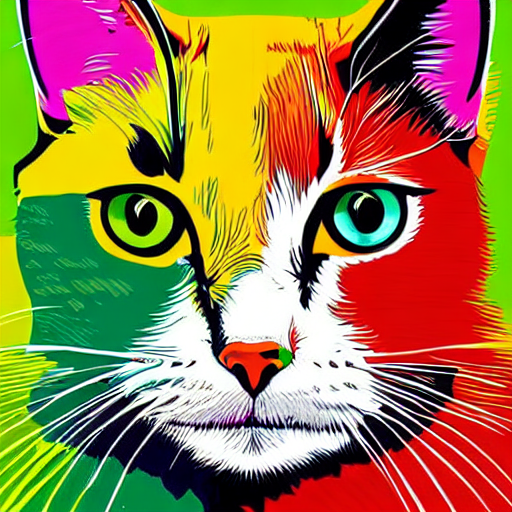

In [33]:
agent.run("Generate an image of a cat in a pop art style")

In [23]:
launch_fn()
transcription = transcribe()
agent.run(transcription)

Listening for wake word...
Start speaking...


UnboundLocalError: ignored